In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd Experiment_Data/

/home/eburn/projects/tacit/Experiment_Data


In [3]:
import os
import datetime
import pandas as pd

def dt_from_js_datestr(datestr):
    date, time = datestr.split(", ")
    month, day, year = map(int, date.split("/"))
    hour, minute, second = map(int, time[:-3].split(":"))
    if time[-2:] == "PM" and hour != 12:
        hour += 12
    return datetime.datetime(year, month, day, hour, minute, second)
    
def process_struct(structstr):
    global startdate
    date, weight = structstr.split(", a new structure of weight ")
    date = dt_from_js_datestr(date)
    if startdate is None:
        startdate = date
    date = date - startdate
    weight = float(weight)
    if weight >= 1e5:
        weight = None
    return date.total_seconds(), weight
    
structs = {}
for f in os.listdir("."):
    if "tutorial" not in f:
        id1, id2, _, problem, tool = f[:-4].split("_")
        idn = int(id1 if id2 == "ID" else id2)
        structs[(idn, problem, tool)] = []
        startdate = None
        laststruct = None
        beamcount = 0
        onloadedstruct = False
        with open(f) as f:
            for line in f:
                if " >> " in line and not onloadedstruct:
                    beamcount += 1
                elif line and line[0] == "#":
                    split = line[:-1].split("# at ")
                    if len(split) <= 1:
                        if "loaded" in line:
                            onloadedstruct = True
                    else:
                        _, structstr = split
                        if laststruct:
                            time, weight = process_struct(laststruct)  # remove trailing newline
                            if weight:
                                if beamcount > 2:
                                    if structs[(idn, problem, tool)]:
                                        prev = structs[(idn, problem, tool)][-1][3]
                                        best = weight if weight < prev else prev
                                    else:
                                        best = weight
                                    structs[(idn, problem, tool)].append((time, weight, beamcount, best))
                            beamcount = 0
                            onloadedstruct = False
                        laststruct = structstr
        time, weight = process_struct(laststruct)  # remove trailing newline
        if weight:
            prev = structs[(idn, problem, tool)][-1][3]
            best = weight if weight < prev else prev
            structs[(idn, problem, tool)].append((time, weight, beamcount, best))
        if structs[(idn, problem, tool)]:
            structs[(idn, problem, tool)] = array(structs[(idn, problem, tool)]).T
        else:
            del structs[(idn, problem, tool)]

454


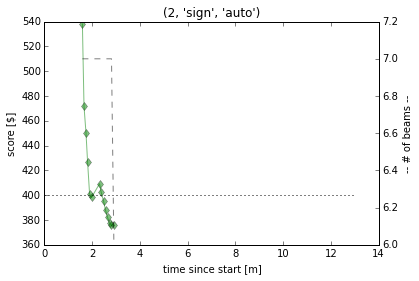

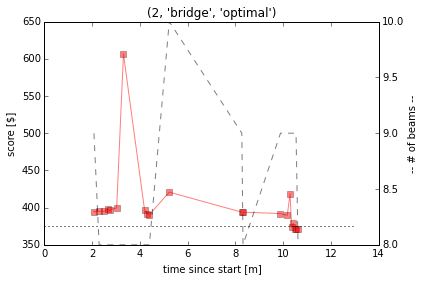

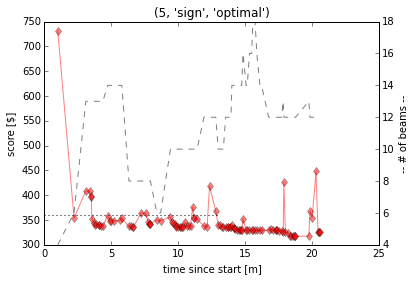

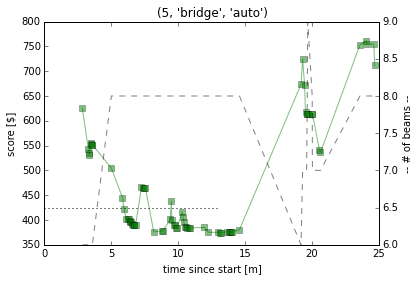

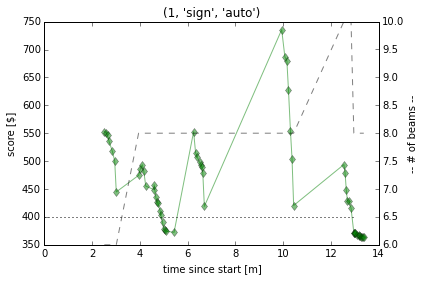

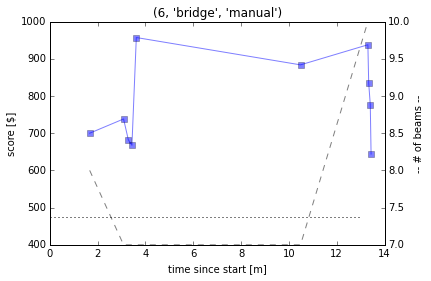

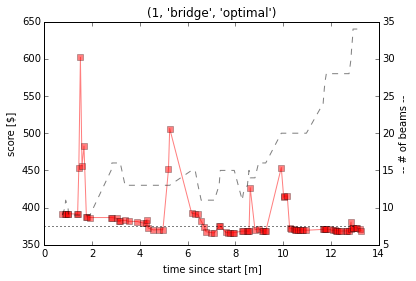

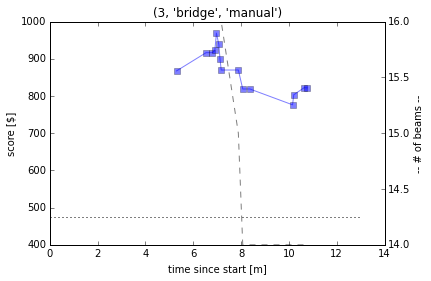

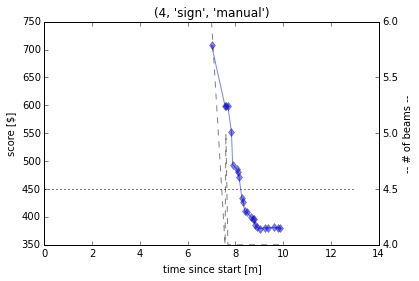

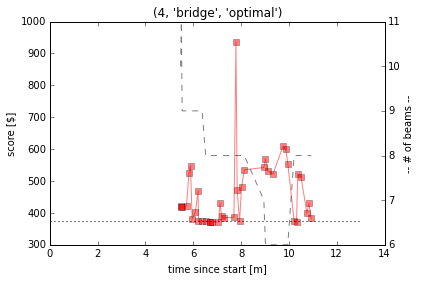

In [64]:
colors = {"optimal": "r", "auto": "g", "manual": "b"}
shapes = {"bridge": "s-", "road sign": "d-", "sign": "d-"}
thresh = {"bridge": {"optimal": 375, "auto": 425, "manual": 475},
          "sign": {"optimal": 360, "auto": 400, "manual": 450},
          "road sign": {"optimal": 360, "auto": 400, "manual": 450}}

# figure(figsize=(12,12))
count = 0
for key, value in structs.items():
    fig, ax1 = plt.subplots()
    id, problem, tool = key
    x, y, c, b = value
    count += len(x)
    ax1.plot(x/60, y/100, colors[tool]+shapes[problem], alpha=0.5)
    ax1.set_title(str(key))
    ax1.set_xlabel("time since start [m]")
    ax1.set_ylabel("score [$]")
    ax1.plot([0, 13], [thresh[problem][tool], thresh[problem][tool]], ":k")
    ax2 = ax1.twinx()
    ax2.plot(x/60, c, "k--", alpha=0.5)
    ax2.set_ylabel("-- # of beams --")

print count

In [5]:
from scipy.interpolate import interp1d

(300, 1050)

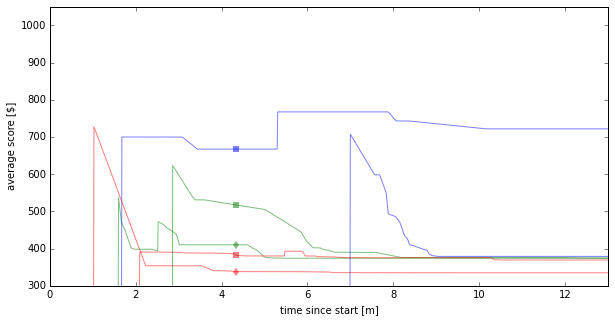

In [58]:
from collections import defaultdict
interpbytool = defaultdict(lambda: defaultdict(lambda: 1000*ones(1000)))
to = linspace(0, 13, 1000)
n = defaultdict(lambda: defaultdict(float))

# interpbytool = defaultdict(float)
# n = defaultdict(float)

colors = {"optimal": "r", "auto": "g", "manual": "b"}
shapes = {"bridge": "s", "road sign": "d", "sign": "d"}

for key, value in structs.items():
    id, problem, tool = key
    if problem == "sign":
        problem = "road sign"
    t, s, c, b = value
    interp = interp1d(t/60, b/100, bounds_error=False,
                      fill_value=(b[0]/100, b[-1]/100.0))
    n[tool][problem] += 1
#     for i, value in enumerate(interp(to)):
#         if value != 1000.0:
    interpbytool[tool][problem] *= (n[tool][problem]-1)/n[tool][problem]
    interpbytool[tool][problem] += interp(to)/n[tool][problem]
#     n[tool] += 1
#     interpbytool[tool] *= (n[tool]-1)/n[tool]
#     interpbytool[tool] += interp(to)/n[tool]
    
figure(figsize=(10,5))
for tool in interpbytool:
    for problem in interpbytool[tool]:
        y = interpbytool[tool][problem]
        plot(to, y, colors[tool]+"-", alpha=0.5)
        plot([to[len(to)/3]], [y[len(to)/3]], colors[tool]+shapes[problem], alpha=0.5,
            markeredgewidth=0.0)

xlabel("time since start [m]")
xlim([0, 13])
ylabel("average score [$]")
ylim([300, 1050])

(300, 1050)

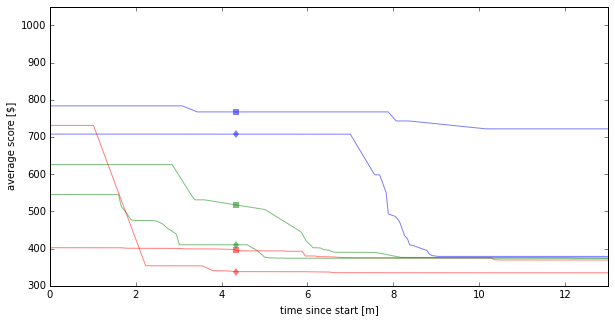

In [61]:
from collections import defaultdict
interpbytool = defaultdict(lambda: defaultdict(lambda: 1000*ones(1000)))
to = linspace(0, 13, 1000)
n = defaultdict(lambda: defaultdict(float))

# interpbytool = defaultdict(float)
# n = defaultdict(float)

colors = {"optimal": "r", "auto": "g", "manual": "b"}
shapes = {"bridge": "s", "road sign": "d", "sign": "d"}

for key, value in structs.items():
    id, problem, tool = key
    if problem == "sign":
        problem = "road sign"
    t, s, c, b = value
    interp = interp1d(t/60, b/100, bounds_error=False,
                      fill_value=(b[0]/100, b[-1]/100.0))
    n[tool][problem] += 1
    interpbytool[tool][problem] *= (n[tool][problem]-1)/n[tool][problem]
    interpbytool[tool][problem] += interp(to)/n[tool][problem]
#     n[tool] += 1
#     interpbytool[tool] *= (n[tool]-1)/n[tool]
#     interpbytool[tool] += interp(to)/n[tool]
    
figure(figsize=(10,5))
for tool in interpbytool:
    for problem in interpbytool[tool]:
        y = interpbytool[tool][problem]
        plot(to, y, colors[tool]+"-", alpha=0.5)
        plot([to[len(to)/3]], [y[len(to)/3]], colors[tool]+shapes[problem], alpha=0.5,
            markeredgewidth=0.0)

xlabel("time since start [m]")
xlim([0, 13])
ylabel("average score [$]")
ylim([300, 1050])

In [21]:
i = interp1d([1, 2], [1, 2], bounds_error=False, fill_value=(1000.0, 18.0))
i([0, 1.5, 3])

array([ 1000. ,     1.5,    18. ])

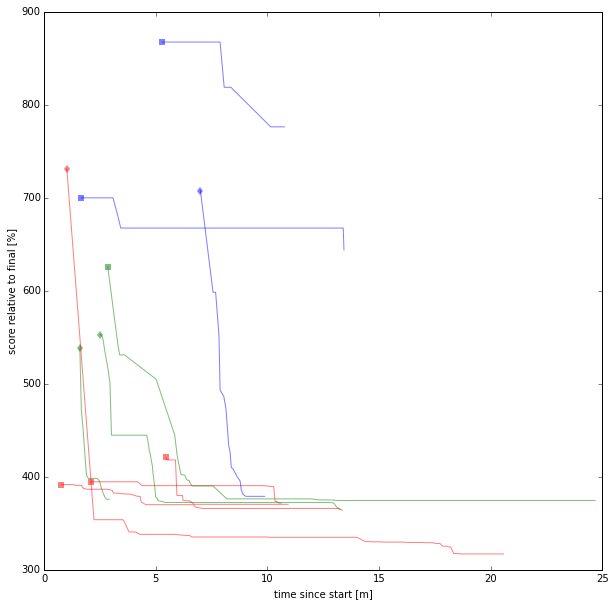

In [430]:
colors = {"optimal": "r", "auto": "g", "manual": "b"}
shapes = {"bridge": "s", "road sign": "d", "sign": "d"}

fig, ax1 = plt.subplots(figsize=(10,10))
for key, value in structs.items():
    id, problem, tool = key
    x, y, c, b = value
#     b /= b[-1]
    ax1.plot(x/60, b/100, colors[tool]+"-", alpha=0.5)
    ax1.plot([x[0]/60], [b[0]/100], colors[tool]+shapes[problem], alpha=0.5,
            markeredgewidth=0.0)
#     ax1.set_title(str(key))
    ax1.set_xlabel("time since start [m]")
    ax1.set_ylabel("score relative to final [%]")
#     ax1.set_ylim([100, 125])
#     ax1.set_xlim([0, 13])
#     ax2 = ax1.twinx()
#     ax2.plot(x/60, c, "k--", alpha=0.5)
#     ax2.set_ylabel("-- # of beams --")

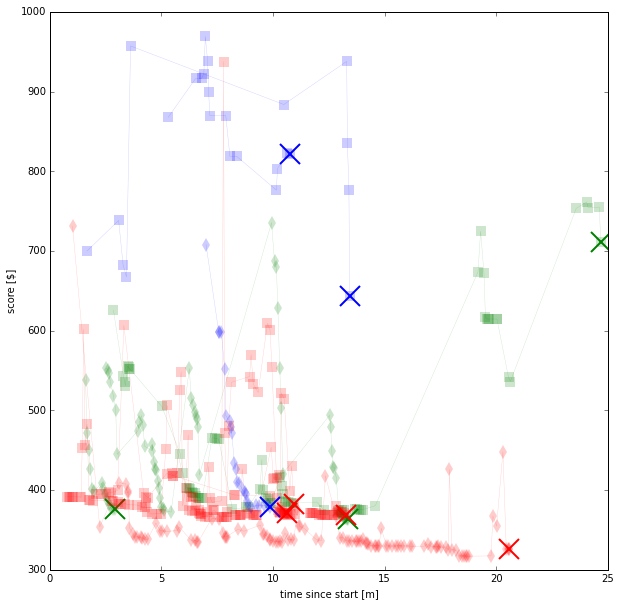

In [295]:
colors = {"optimal": "r", "auto": "g", "manual": "b"}
shapes = {"bridge": "s-", "road sign": "d-", "sign": "d-"}

fig, ax1 = plt.subplots(figsize=(10,10))
for key, value in structs.items():
    id, problem, tool = key
    x, y, c = value
    ax1.plot(x/60, y/100, colors[tool]+shapes[problem], alpha=0.2, markersize=10,
             fillstyle="full", markeredgewidth=0.0, linewidth=0.4)
    ax1.plot(x[-1]/60, y[-1]/100, colors[tool]+"x", markersize=20, markeredgewidth=2)
#     ax1.set_title(str(key))
    ax1.set_xlabel("time since start [m]")
    ax1.set_ylabel("score [$]")

In [17]:
import pandas as pd
import datetime

In [38]:
bytool = {}

for key, value in structs.items():
    id, problem, tool = key
    if problem == "sign":
        problem = "road sign"
    t, s, c, b = value
    if tool not in bytool:
        bytool[tool] = {}
    if problem not in bytool[tool]:
        bytool[tool][problem] = []
    bytool[tool][problem].append(row_stack((c, s)))

for tool in bytool:
    for problem in bytool[tool]:
        if not hasattr(bytool[tool][problem], "shape"):
            bytool[tool][problem] = concatenate(bytool[tool][problem], axis=1)

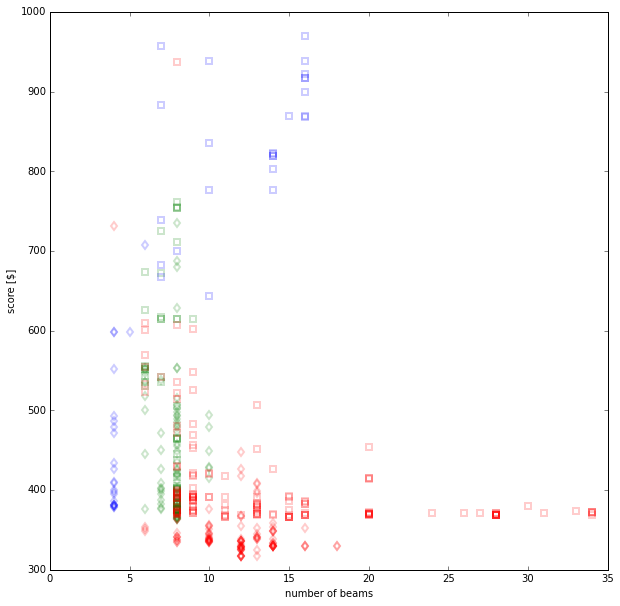

In [40]:
colors = {"optimal": "r", "auto": "g", "manual": "b"}
shapes = {"bridge": "s", "road sign": "d", "sign": "d"}
figure(figsize=(10,10))

for tool in bytool:
    for problem in bytool[tool]:
        if not hasattr(bytool[tool][problem], "shape"):
            bytool[tool][problem] = concatenate(bytool[tool][problem], axis=1)
        x, y = bytool[tool][problem]
        A = np.vstack([x, np.ones(len(x))]).T
        m, c = np.linalg.lstsq(A, y)[0]
        color = matplotlib.colors.ColorConverter().to_rgba(colors[tool], alpha=0.2)
        xb = array([min(x), max(x)])
#         plot(xb, (m*xb+c)/100, colors[tool]+shapes[problem]+"-", alpha=0.7,
#              markeredgewidth=0.0, markersize=10)
        plot(x, y/100, colors[tool]+shapes[problem], alpha=0.2, markersize=6,
             markeredgewidth=2, markeredgecolor=color, markerfacecolor="none")
#     title(str(key))
#     figure()
#     ylim([0, 1000])
#     xlim([0, 20])
xlabel("number of beams")
ylabel("score [$]")